# Exercise 2.2: Fully-convolutionalize a network.
**Fully-convolutionalize** a traditional convolutional neural network. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

### Training a traditional convolutional neural network
In the first part of this notebook we trained a traditional neural network as in exercise 1 on MNIST.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torch.utils.tensorboard import SummaryWriter
import wandb
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import wandb
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor

In [33]:
batch_size = 64
lr = 0.0001
momentum = 0.9
weight_decay = 1e-04
epochs = 10
WANDB = False
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    device = torch.device("cuda")  # to use the GPU
else:
    device = torch.device("cpu")

#### Data preparation

Here we load MNIST dataset, creating a validation splitting evaluate the models during training.

In [34]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

# Dataloaders.
trainloader = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=0)
valloader   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
testloader  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=0)


#### Training and evaluation Functions 

Training, evaluation, and plotting code. The final method counts the number of trainable parameters in the network.

In [35]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report


# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, criterion, epoch='Unknown', device='cpu', fully_conv=False):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        if fully_conv:
            _, _, a, b = logits.shape
            gts = ys.unsqueeze(-1).unsqueeze(-1).repeat(1,a,b)
            loss = criterion(logits, gts)
        else:
            loss = criterion(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    if WANDB:
        wandb.log({'Train Loss': np.mean(losses)})
    else:
        return np.mean(losses)


# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, criterion, device='cpu', val=False):
    model.eval()
    test_loss = 0
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        output = model(xs)
        preds = torch.argmax(output, dim=1)
        test_loss += criterion(output, ys.to(device)).item()
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
    mode = "Val" if val else "Test"
    if not val:
        print('\{} set: Average loss: {:.4f}, Accuracy: {:.0f}%\n'.format(
            mode,
            test_loss/len(dl), accuracy_score(np.hstack(gts), np.hstack(predictions))))   
    # Return accuracy score and classification report.
    if WANDB:
        wandb.log({'Test Loss': test_loss / len(dl),
                   'Test Accuracy': round(accuracy_score(np.hstack(gts), np.hstack(predictions)), 2)})
    else:
        return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))


# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')


def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#### Main model backbone

In [36]:
class CNN(nn.Module):
    def __init__(self, input_channels, output_dim = 10):
        super().__init__()
        hidden_dim = 32
        self.conv1 = nn.Conv2d(input_channels, hidden_dim, kernel_size=3, stride = 2, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, stride = 2, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, stride = 1, padding=1)
        self.conv4 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=3, stride = 1, padding=1)
        self.classifier = nn.Sequential(
            nn.Linear(12544, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        return self.classifier(x.flatten(1))

#### Training the main model
Here we train the traditional CNN to classify MNIST digits.

In [37]:
convnet = CNN(1, 10).to(device)
print(convnet)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [8]:
convnet = torch.load('models/FullyConvolutionalNetwork/convnet.pth')

In [38]:
optimizer = torch.optim.Adam(params=convnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
losses_and_accs = []
for epoch in range(1, epochs+1):
    loss = train_epoch(convnet, trainloader, optimizer, criterion, epoch, device=device)
    # evaluate_model(convnet, valloader, criterion, device=device, val=True)   
    (val_acc, _) = evaluate_model(convnet, valloader, criterion, device=device, val=True) 
    losses_and_accs.append((loss, val_acc))

Training epoch 10: 100%|██████████| 860/860 [00:22<00:00, 39.03it/s]


\Test set: Average loss: 0.0461, Accuracy: 1%


(0.9869,
 '              precision    recall  f1-score   support\n\n           0      0.993     0.995     0.994       980\n           1      0.996     0.992     0.994      1135\n           2      0.987     0.995     0.991      1032\n           3      0.978     0.992     0.985      1010\n           4      0.994     0.983     0.988       982\n           5      0.966     0.989     0.977       892\n           6      0.992     0.975     0.983       958\n           7      0.985     0.991     0.988      1028\n           8      0.996     0.977     0.987       974\n           9      0.982     0.978     0.980      1009\n\n    accuracy                          0.987     10000\n   macro avg      0.987     0.987     0.987     10000\nweighted avg      0.987     0.987     0.987     10000\n')

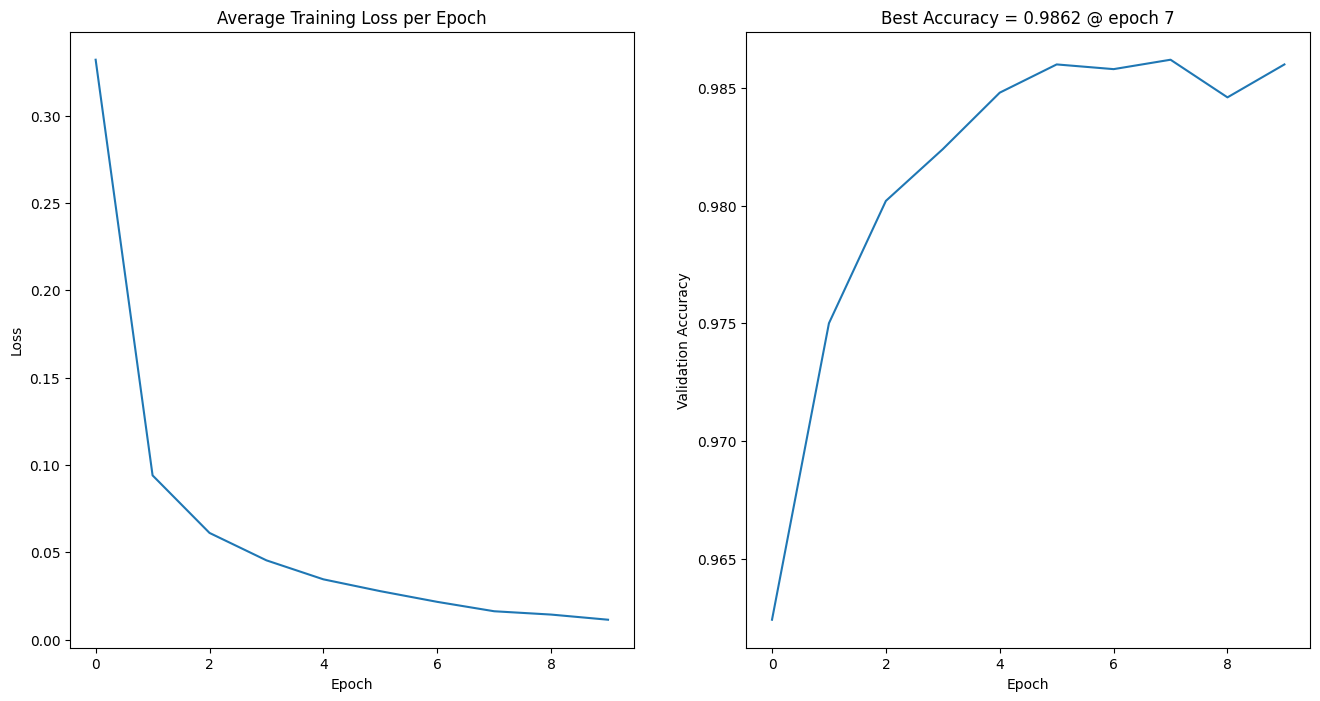

In [40]:
plot_validation_curves(losses_and_accs)
evaluate_model(convnet, testloader, criterion, device=device, val=False)

In [41]:
torch.save(convnet, 'models/FullyConvolutionalNetwork/convnet.pth')

### Fully convolutional model
Here we create a fully convolutional network which uses the feature representation of the previous network and produces a prediction for each pixel.

In [42]:
class FCN(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = nn.Sequential(*list(pretrained_net.children())[:-1])
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(64)
        self.classifier = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        score = self.bn1(self.relu(self.deconv1(output)))    
        score = self.bn2(self.relu(self.deconv2(score)))  
        score = self.classifier(score)                    
        return score  

In [102]:
print(nn.Sequential(*list(convnet.children())[:-1]))

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [51]:
fcn_model = FCN(convnet, 10).to(device)
count_trainable_parameters(fcn_model)

369866

In [15]:
fcn_model = torch.load('models/FullyConvolutionalNetwork/fcn_model.pth')

In [63]:
for param in fcn_model.pretrained_net.parameters():
        param.requires_grad = False
count_trainable_parameters(fcn_model)

757706

In [53]:
optimizer = torch.optim.Adam(fcn_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [77]:
for epoch in range(10):  # Loop over the dataset multiple times
    train_epoch(fcn_model, trainloader, optimizer, criterion, epoch, device=device, fully_conv=True)

print('Finished Training')

Training epoch 9: 100%|██████████| 860/860 [00:28<00:00, 29.82it/s]

Finished Training


In [76]:
torch.save(fcn_model, 'models/FullyConvolutionalNetwork/fcn_model.pth')

### Evaluate on multisize images
Here we show the outputs of the obtained network on a dataset that incorporates the MNIST digits in a random position of a larger image.

In [78]:
from torch.utils.data import Dataset
from PIL import Image

class MultiSizeMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, image_size=32):
        super().__init__()
        self.dataset = MNIST(root, train, transform, target_transform, download)
        self.transform = transform
        self.image_size = image_size

    def __getitem__(self, index):
        img, target = self.dataset[index]
        #make a new image and place the original image somewhere in the new image
        new_img = Image.new('1', (self.image_size, self.image_size), 0)
        convert_to_pil = transforms.ToPILImage()
        new_img = self.transform(new_img)
        #sum the two tensors but img is shifted by 16 pixels
        #pick two random numbers between 0 and 32
        x = np.random.randint(0, self.image_size - 28)
        y = np.random.randint(0, self.image_size - 28)
        #sum two tensors of different shape
       # print(new_img.shape, img.shape)
        new_img[:,x:x+28, y:y+28] = img
        return new_img, target, x, y
    def __len__(self):
        return len(self.dataset)

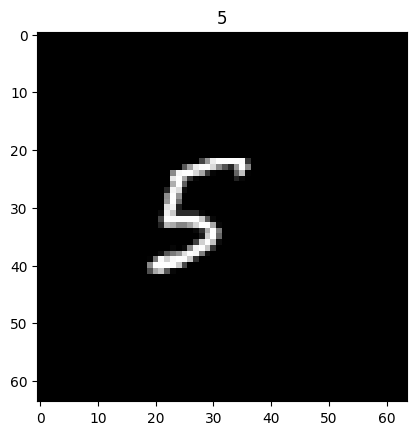

In [80]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
mnist_alt = MultiSizeMNIST(root='./data', train=False, download=True, transform=transform, image_size=64)
#print an image from the dataset
img, target, _, _ = mnist_alt[23]
img = img.permute(1,2,0)
plt.imshow(img, cmap='gray')
plt.title(target)
plt.show()

In [110]:
print(len(mnist_alt))

10000


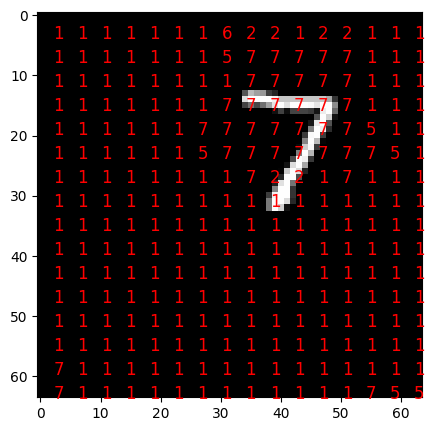

In [148]:
for i in range(1):
    img, _, _, _= mnist_alt[i]
    img = img.unsqueeze(0).to(device)
    output = fcn_model(img)
    pred = torch.argmax(output, 1).squeeze()
    # plt.figure(figsize=(5,5))
    # plt.imshow(img.cpu().squeeze().numpy(), cmap = 'gray')


    plt.figure(figsize=(5,5))
    plt.imshow(img.cpu().squeeze().numpy(), cmap = 'gray')
    for i in range(3, pred.shape[0], 4):
        for j in range(3, pred.shape[1], 4):
            plt.text(j, i, str(pred[i,j].item()),ha='center', va='center', color = 'red', fontsize = 12)
    break


The above image shows the results of the predictions made by our network. (The image shows a prediction every 4 pixels to have a clearer layout). Interestingly, the network produces the correct output for most pixels of the 28x28 MNIST digit, while it predicts 1 on all the others. This results seems to suggest that where there is no image of a digit the network outputs the class of the smaller (in terms of # of black pixels) digit of the dataset

### Multi-image MNIST
In this case we replicate the same experiment but the dataset incorporates 2 digits inside a larger image. As s

In [83]:
class MultiImageMNIST(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, image_size=56):
        super().__init__()
        self.dataset = MNIST(root, train, transform, target_transform, download)
        self.transform = transform
        self.image_size = image_size

    def __getitem__(self, index):
        img, target = self.dataset[index]
        img2, target2 = self.dataset[np.random.randint(0, len(self.dataset))]  
        #make a new image and place the original image somewhere in the new image
        new_img = Image.new('1', (self.image_size, self.image_size), 0)
        convert_to_pil = transforms.ToPILImage()
        new_img = self.transform(new_img)
        #sum the two tensors but img is shifted by 16 pixels
        #pick two random numbers between 0 and 32
        x = np.random.randint(0, self.image_size//2 - 28  + 1)
        y = np.random.randint(0, self.image_size - 28)
        #sum two tensors of different shape
        #print(new_img.shape, img.shape)
        new_img[:,x:x+28, y:y+28] = img
        x = np.random.randint(self.image_size//2, self.image_size - 28 + 1)
        y = np.random.randint(0, self.image_size - 28)
        new_img[:,x:x+28, y:y+28] = img2
        # new_img = convert_to_pil(new_img)
        return new_img, target, target2
    
    def __len__(self):
        return len(self.dataset)

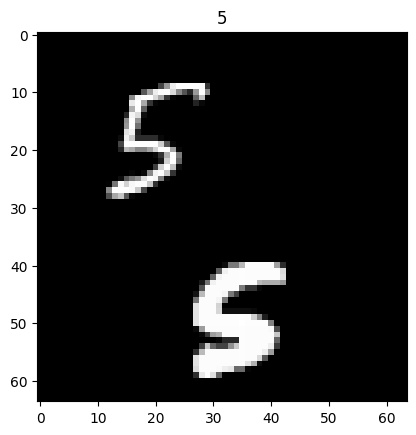

In [84]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
mnist_alt = MultiImageMNIST(root='./data', train=False, download=True, transform=transform, image_size=64)
#print an image from the dataset
img, target, target2 = mnist_alt[23]
img = img.permute(1,2,0)
plt.imshow(img, cmap='gray')
plt.title(target)
plt.show()

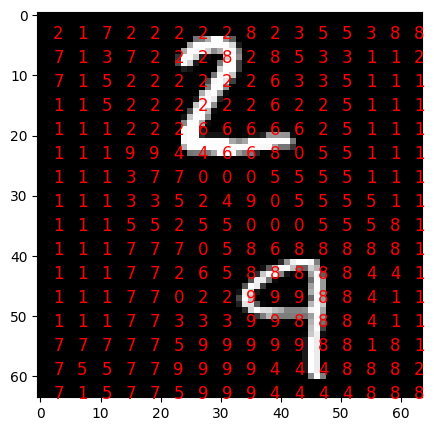

In [88]:
for i in range(1):
    img, _, _= mnist_alt[i]
    img = img.unsqueeze(0).to(device)
    output = fcn_model(img)
    pred = torch.argmax(output, 1).squeeze()
    # plt.figure(figsize=(5,5))
    # plt.imshow(img.cpu().squeeze().numpy(), cmap = 'gray')


    plt.figure(figsize=(5,5))
    plt.imshow(img.cpu().squeeze().numpy(), cmap = 'gray')
    for i in range(3, pred.shape[0], 4):
        for j in range(3, pred.shape[1], 4):
            plt.text(j, i, str(pred[i,j].item()),ha='center', va='center', color = 'red', fontsize = 12)
    break
